In [5]:
import numpy as np
import tensorflow as tf
import time 
from matplotlib import pyplot as plt

# Getting Data Ready for training and testing

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = 'data'
source_dir = os.path.join(base_dir, 'PetImages')
training_dir = os.path.join(base_dir, 'training')
testing_dir = os.path.join(base_dir, 'testing')

# Create directories for training and testing data
for category in ['cats', 'dogs']:
    os.makedirs(os.path.join(training_dir, category), exist_ok=True)
    os.makedirs(os.path.join(testing_dir, category), exist_ok=True)

# Function to split images and copy them to train/test directories
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(f"Skipping {filename} due to zero size")

    train_files, test_files = train_test_split(files, test_size=SPLIT_SIZE)

    for filename in train_files:
        src_file = os.path.join(SOURCE, filename)
        dst_file = os.path.join(TRAINING, filename)
        shutil.copyfile(src_file, dst_file)

    for filename in test_files:
        src_file = os.path.join(SOURCE, filename)
        dst_file = os.path.join(TESTING, filename)
        shutil.copyfile(src_file, dst_file)



# Create directories for training and testing data if they do not exist
if not os.path.exists(training_dir):
    os.makedirs(training_dir)
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(training_dir, category), exist_ok=True)

if not os.path.exists(testing_dir):
    os.makedirs(testing_dir)
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(testing_dir, category), exist_ok=True)
        
        
# Split data with 0.1 test size
split_size = 0.1

split_data(os.path.join(source_dir, 'Cat'), os.path.join(training_dir, 'cats'), os.path.join(testing_dir, 'cats'), split_size)
split_data(os.path.join(source_dir, 'Dog'), os.path.join(training_dir, 'dogs'), os.path.join(testing_dir, 'dogs'), split_size)

print("Data split completed.")


Skipping 666.jpg due to zero size
Skipping 11702.jpg due to zero size
Data split completed.


## Data Augmentation on Train and Test Images

In [6]:
from tensorflow.keras.preprocessing.image  import ImageDataGenerator


augment_train = 1
augment_test = 0      # I don't wanna augment validation Data !

# define training data augmentation pipeline
if augment_train:
      train_datagen = ImageDataGenerator( rescale = 1.0/255.,
            rotation_range=40,                    # rotates the img randomly by (0-40 degrees) 
            width_shift_range=0.2,                # shift the img's width randomly by (0-20)percent of input img width
            height_shift_range=0.2,
            shear_range=0.2,                      # gives sq img the rhombic shape, seems like img is taken from an angle
            zoom_range=0.2,                       # zoom in or out the input img by upto 20%
            horizontal_flip=True,
            fill_mode='nearest')
else :
      train_datagen = ImageDataGenerator(rescale=1.0/255.)

# load training data
TRAINING_DIR = 'data/training'
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=1024,
                                                    class_mode='binary',      # Since we only have 2 classes, either cat or dog
                                                                              # for multiple classes use categorical cross entropy
                                                    target_size=(150, 150))   # Resizes the img to (150,150)






# define test data augmentation pipeline
if augment_test:
      validation_datagen = ImageDataGenerator( rescale = 1.0/255.,
            rotation_range=40,                 
            width_shift_range=0.2,               
            height_shift_range=0.2,
            shear_range=0.2,                     
            zoom_range=0.2,                       
            horizontal_flip=True,
            fill_mode='nearest')
else:
      validation_datagen = ImageDataGenerator(rescale=1.0/255.)
      
# load test data
VALIDATION_DIR = 'data/testing'
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=1024,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


## Model Architecture and Compilation

# Transfer Learning

Using pre-trained InceptionV3 model

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,              # I don't want last layer, as Inception was ment for some other 
                                                                  # 10 classes classification based on IMAGENET data
                                                                  # I will use same model with weights and add some custom layers 
                                                                  # to train new layers on dags vs cats only
                                weights = None)           

pre_trained_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model.load_weights(pre_trained_weights_file)

pre_trained_model.trainable = False   # It's important to make it False, as we don't want to train over 21 Million + weights/parameters

pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

# Extract part of Pre-Trained InceptionV3 Model

In [6]:
last_output = pre_trained_model.get_layer('activation_90').output

base_model = tf.keras.Model(pre_trained_model.input, last_output)

base_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 18,191,008 (69.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,191,008 (69.39 MB)

# Add our own custom layers

In [7]:
# initialize the model
extended_model = tf.keras.Sequential([
    # base model (part of Inception V3)
    base_model,
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'), 
    
    # 64 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'), 

    # Only 1 output neuron.
    # It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
extended_model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"])

# print model summary
extended_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ ?                      │    18,191,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,191,008 (69.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,191,008 (69.39 MB)

# Training/Fine-Tunning InceptionV3

In [13]:
# define callback function for training termination criteria
#accuracy_cutoff = 0.93
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') > 0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

# initialize training config
epochs = 30

pTime = time.time()
# run training
history = extended_model.fit(train_generator, validation_data=validation_generator,
                    epochs=epochs, verbose=1, callbacks=[myCallback()])
cTime = time.time()

print(f"Time taken in Fine Tunning InceptionV3 = {cTime-pTime}")

Epoch 1/30
11/22 ━━━━━━━━━━━━━━━━━━━━ 2:54 16s/step - accuracy: 0.9368 - loss: 0.1449

c:\Users\shory\anaconda3\envs\myenv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9355 - loss: 0.1475 
Reached 93% accuracy so cancelling training!
22/22 ━━━━━━━━━━━━━━━━━━━━ 373s 15s/step - accuracy: 0.9355 - loss: 0.1476 - val_accuracy: 0.9576 - val_loss: 0.0960
Time taken in Fine Tunning InceptionV3 = 379.36392307281494


In [ ]:
extended_model.save_weights("FineTuneInception.weights.h5")
extended_model.save("FineTuneInception.h5")

In [4]:
extended_model = tf.keras.models.load_model("FineTuneInception.h5")

In [15]:
extended_model.evaluate(validation_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.9566 - loss: 0.0970


[0.09597110748291016, 0.9575660824775696]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


C:\Users\shory\AppData\Local\Temp\ipykernel_20032\3739477618.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(np.round(predictions[i]))


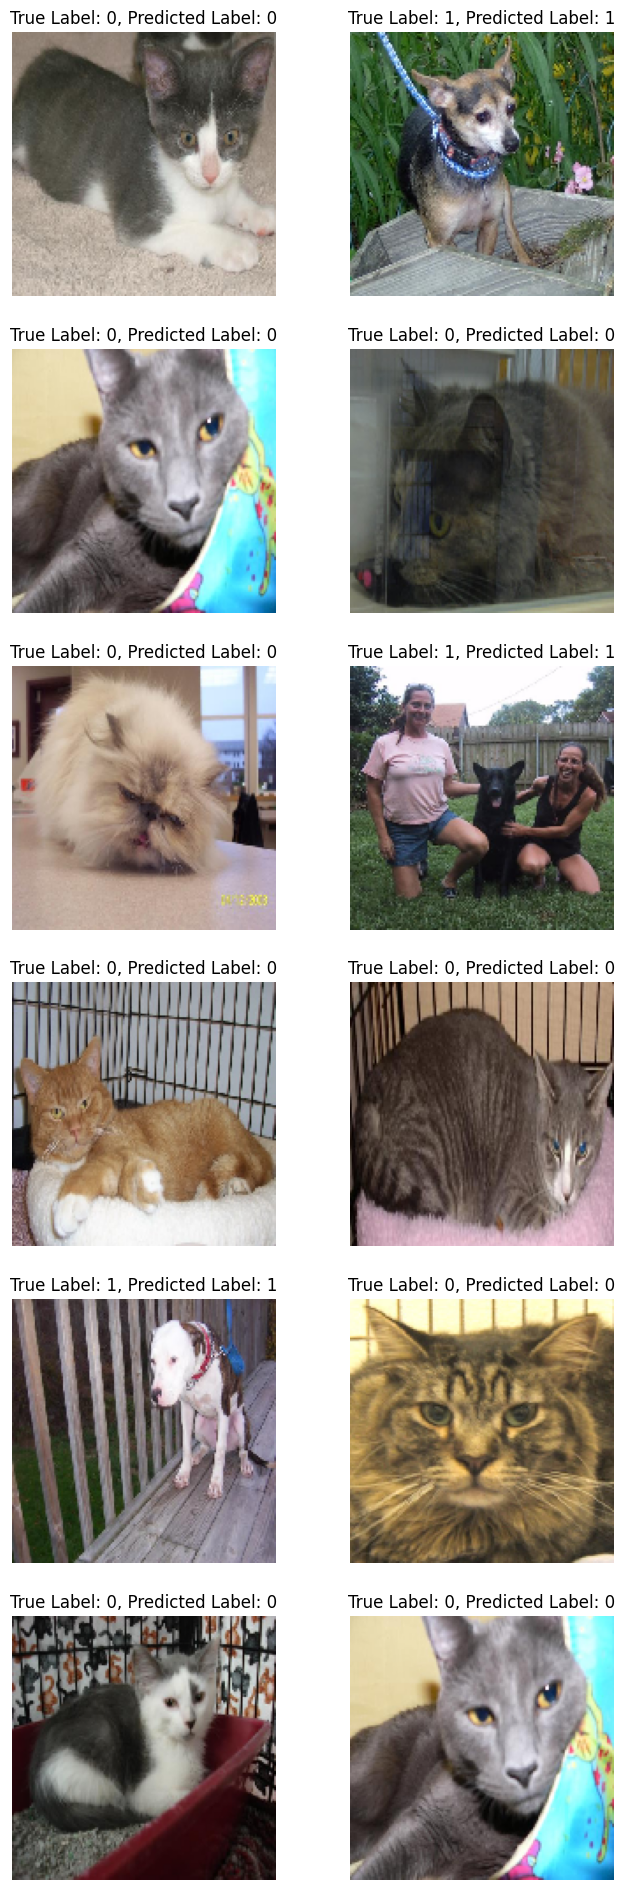

<Figure size 640x480 with 0 Axes>

In [8]:
# Set up matplotlib fig, and size it to fit 3x4 pics
nrows = 6
ncols = 2
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Randomly select a few testing samples
num_predictions = 12
test_images, test_labels = next(validation_generator)
test_indices = np.random.choice(np.arange(0, len(test_images)), size=num_predictions)
test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

# Compute predictions
predictions = extended_model.predict(test_images)

for i in range(num_predictions):
    # Select the most probable class
    prediction = int(np.round(predictions[i]))

    # Rescale the test image
    image = (test_images[i] * 255).astype("uint8")

    # Show the image with true label and predicted label
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)
    plt.title(f'True Label: {int(test_labels[i])}, Predicted Label: {prediction}')
    plt.axis('off')
    
plt.show()
plt.savefig("some-predictions.png")